In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mysql.connector
import pandas as pd
import numpy as np

import mysql.connector
import pandas as pd

# MySQL 연결 설정
cnx = mysql.connector.connect(
    host='',
    user='',
    password='',
    database='ball_movement'
)

# 쿼리 생성
query_ball = "SELECT * FROM ball_df"
query_events_df = "SELECT * FROM events_df"
query_sequence_df = "SELECT * FROM sequence_df"

# DataFrame으로 읽기
ball_df = pd.read_sql(query_ball, con=cnx)
events_df = pd.read_sql(query_events_df, con=cnx)
sequence_df = pd.read_sql(query_sequence_df, con=cnx)

# 연결 종료 (선택적)
cnx.close()

이제 이 정보를 바탕으로 홈오그래피 매트릭스를 계산하고, 이를 통해 좌표 변환을 진행합니다.

In [46]:
import cv2
import pandas as pd
import numpy as np

# Define the coordinates in the camera view and the corresponding real-world coordinates
camera_points = np.float32([[305, 103], [510, 217], [1297, 202], [1435, 76]])
real_world_points = np.float32([[0, 0], [0, 1525], [2740, 1525], [2740, 0]])

# Compute the perspective transformation matrix
perspective_transform_matrix = cv2.getPerspectiveTransform(camera_points, real_world_points)

# Apply the perspective transformation to each point in the dataframe
transformed_points = cv2.perspectiveTransform(np.array([ball_df[['x', 'y']].values], dtype='float32'), perspective_transform_matrix)[0]

# Create a new dataframe with the transformed coordinates
transformed_df = pd.DataFrame(transformed_points, columns=['x_transformed', 'y_transformed'])
transformed_df['frame'] = ball_df['frame']  # Include the frame number for reference

ball_df[['x', 'y']] = transformed_df[['x_transformed','y_transformed']]

ball_df[['x', 'y']] = ball_df[['x', 'y']].round().astype('Int64')

ball_df.head()

,index,sequence,frame,x,y,player
0,0,1,15,57,1493,player_A
1,1,1,16,134,1408,player_A
2,2,1,17,222,1293,player_A
3,3,1,18,283,1248,player_A
4,4,1,19,299,1335,player_A


이제 이렇게 변환된 좌표를 활용하여 기존의 EDA를 진행합니다.

In [47]:
ball_df = ball_df.drop(columns='index')
events_df = events_df.drop(columns='level_0')

**ball_df**에서 **frame**은 동영상의 프레임 번호, **x**,**y**는 공의 좌표이다

In [48]:
# Merging the dataframes on the 'frame' column to align the rows where frames match
merged_df = pd.merge(events_df, ball_df[['frame', 'x', 'y']], on='frame', how='left')

events_df['x'] = merged_df['x_y']
events_df['y'] = merged_df['y_y']

events_df = events_df.drop(columns='index')
events_df.head()

,frame,x,y,event,player,height,bounce
0,18,283,1248,bounce,player_A,NaN,left
1,33,1346,1883,net,player_A,30.41,None
2,44,355,393,bounce,player_A,NaN,right
3,2192,2500,289,bounce,player_A,NaN,right
4,2211,1298,2143,net,player_A,67.23,None


In [49]:
# ball_df.to_csv('bounce/ball_df.csv')
# events_df.to_csv('bounce/events_df.csv')
# sequence_df.to_csv('bounce/sequence_df.csv')

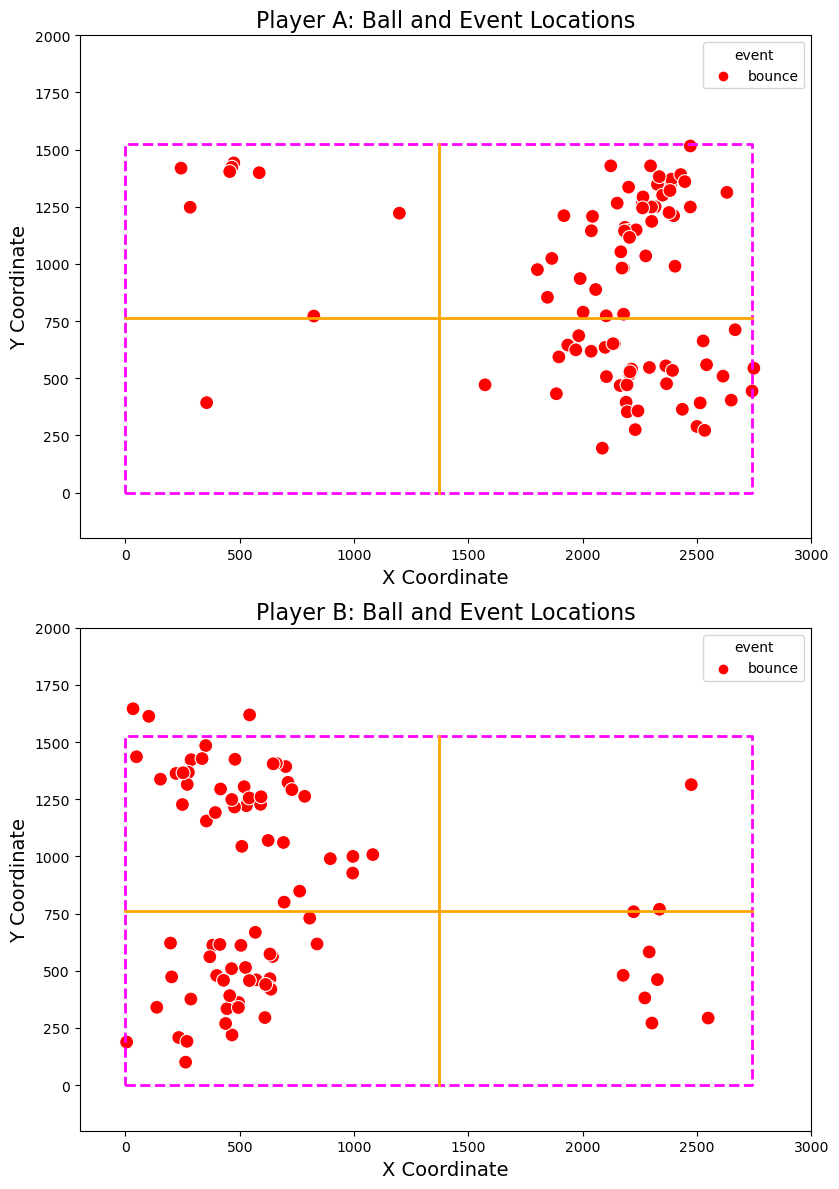

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 기존 코드의 일부 (데이터 프레임과 관련된 부분은 생략)

# Define colors and markers for the events
event_colors = {'bounce': 'red', 'net': 'green'}

# Correct the event_markers dictionary to match the 'bounce' and 'net' events
event_markers_corrected = {'bounce': 'o', 'net': 'X'}  # o for bounce, X for net

# 사각형과 선을 그리기 위한 좌표
rectangle_coords = [(0, 0), (2740, 0), (2740, 1525), (0, 1525), (0, 0)]  # 사각형 좌표 (시작점으로 돌아감)
line_coords_1 = [(1370, 0), (1370, 1525)]  # 네트선
line_coords_2 = [(0, 762.5), (2740, 762.5)]  # 라인선



# Repeating the visualization process with the corrected markers
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# 각 축에 대해 수정된 시각화 추가
for ax in axes:
    # 사각형 그리기
    ax.plot(*zip(*rectangle_coords), color='magenta', linestyle='--', linewidth=2)  # 사각형
    # 두 선 연결
    ax.plot(*zip(*line_coords_1), color='orange', linestyle='-', linewidth=2)  # 네트선
    ax.plot(*zip(*line_coords_2), color='orange', linestyle='-', linewidth=2)  # 라인선


# Player A
# Plot event positions for player A
sns.scatterplot(data=events_df[events_df['player'] == 'player_A'][events_df['event'] == 'bounce'], 
                x='x', y='y', hue='event', style='event',
                ax=axes[0], palette=event_colors, markers=event_markers_corrected, s=100, legend='full')


axes[0].set_title('Player A: Ball and Event Locations', fontsize=16)
axes[0].set_xlabel('X Coordinate', fontsize=14)
axes[0].set_ylabel('Y Coordinate', fontsize=14)

axes[0].set_xlim(-200, 3000)
axes[0].set_ylim(-200, 2000)

# Player B
# Plot event positions for player B
sns.scatterplot(data=events_df[events_df['player'] == 'player_B'][events_df['event'] == 'bounce'], 
                x='x', y='y', hue='event', style='event',
                ax=axes[1], palette=event_colors, markers=event_markers_corrected, s=100, legend='full')


axes[1].set_title('Player B: Ball and Event Locations', fontsize=16)
axes[1].set_xlabel('X Coordinate', fontsize=14)
axes[1].set_ylabel('Y Coordinate', fontsize=14)

axes[1].set_xlim(-200, 3000)
axes[1].set_ylim(-200, 2000)

# Player A와 Player B 축의 aspect ratio를 'equal'로 설정 (찌그러짐 방지)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()


In [43]:
# '바운스' 이벤트 데이터 필터링
bounce_player_A = events_df[(events_df['player'] == 'player_A') & (events_df['event'] == 'bounce')]
bounce_player_B = events_df[(events_df['player'] == 'player_B') & (events_df['event'] == 'bounce')]

# 표준편차 계산
std_player_A = bounce_player_A[['x', 'y']].std().round(2)
std_player_B = bounce_player_B[['x', 'y']].std().round(2)

# 결과 출력
print("플레이어 A의 표준편차 x, y:", f'{std_player_A[0]}, {std_player_A[1]}')
print("플레이어 B의 표준편차 x, y:", f'{std_player_B[0]}, {std_player_B[1]}')

플레이어 A의 표준편차 x, y: 563.9, 387.45
플레이어 B의 표준편차 x, y: 615.27, 445.92


표준편차는 데이터가 평균값으로부터 얼마나 멀리 퍼져 있는지를 나타내는 척도입니다. \
따라서, 표준편차가 큰 플레이어일수록 더 넓은 범위에 걸쳐 공을 치고 있다고 해석할 수 있습니다.

플레이어 A는 x축과 y축 모두에서 상대적으로 낮은 표준편차를 가지고 있습니다. 이는 플레이어 A가 공을 치는 위치가 다소 집중되어 있음을 나타냅니다.\
\
반면, 플레이어 B는 x축과 y축 모두에서 높은 표준편차를 가지고 있어, 탁구대 전반에 걸쳐 더 다양한 지점으로 공을 치는 것으로 해석됩니다.\
\
이러한 분석을 바탕으로, 플레이어 B가 플레이어 A보다 탁구대를 더 넓게 활용하여 공을 치는 것으로 보입니다.

플레이어 별 공의 속도 비교

In [7]:
import pandas as pd

# 각 플레이어 별 공의 경로별 평균속도의 다방성 분석 (mean:평균, std:표준편차, min:최솟값, max: 최댓값, range: 범위)
velocity_stats = sequence_df.groupby('player')['avg_velocity'].agg(['mean', 'std', 'min', 'max'])
velocity_stats['range'] = velocity_stats['max'] - velocity_stats['min']
velocity_stats.reset_index(inplace=True)

velocity_stats

,player,mean,std,min,max,range
0,player_A,17.027317,5.893207,3.87,28.22,24.35
1,player_B,19.255641,7.995080,2.67,36.46,33.79


플레이어 별 공의 높이 비교

In [5]:
import pandas as pd

# 각 플레이어 별 공의 높이의 다방성 분석 (mean:평균, std:표준편차, min:최솟값, max: 최댓값, range: 범위)
height_stats = events_df.groupby('player')['height'].agg(['mean', 'std', 'min', 'max'])
height_stats['range'] = height_stats['max'] - height_stats['min']
height_stats.reset_index(inplace=True)

height_stats

,player,mean,std,min,max,range
0,player_A,0.192857,0.061831,0.03,0.38,0.35
1,player_B,0.199487,0.078887,0.03,0.49,0.46
